# U.S. Inflation rate (CPI) vs Fed Reserve interest rate.

**Objects of Study:**
* Correlation between inflation (CPI) and the Fed Rate 1983 - present.
* CPI and the Fed Rate during US national recessions (1990s, 2000s, Great Recession, Covid-19 recession).
* CPI & the Fed Rate during periods of pre-recessions and post-recessions (1 year before and 1 year after).

**Data:**
- Median Consumer Price Index (MEDCPIM158SFRBCLE)

Median CPI was created as a different way to get a 'Core CPI' measure, or a better measure of underlying inflation trends. To calculate the Median CPI, the Cleveland Fed analyzes the median price change of the goods and services published by the BLS. The median price change is the price change that’s right in the middle of the long list of all of the price changes. This series excludes 49.5% of the CPI components with the highest and lowest one-month price changes from each tail of the price-change distribution resulting in a Median CPI Inflation Estimate.

- the Fed Rate, or the Federal Funds Effective Rate (FEDFUNDS)

The federal funds rate is the interest rate at which depository institutions trade federal funds (balances held at Federal Reserve Banks) with each other overnight. When a depository institution has surplus balances in its reserve account, it lends to other banks in need of larger balances. In simpler terms, a bank with excess cash, which is often referred to as liquidity, will lend to another bank that needs to quickly raise liquidity.

# Data imports

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.ticker as mtick

from pandas import to_datetime, DataFrame
from numpy import inf
from statistics import stdev
from pandas_datareader.data import DataReader

# load packages 
import datetime as dt 
import pandas_datareader as pdr    # data import tools 
import matplotlib.pyplot as plt    # plotting tools 

# The next one is an IPython command:  it says to put plots here in the notebook, rather than open a separate window.
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

2022-10-13 17:15:44.615691: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


,MEDCPIM158SFRBCLE
DATE,
1983-01-01,5.014653
1983-02-01,4.952545
1983-03-01,3.612261
1983-04-01,4.828054
1983-05-01,3.767326
...,...
2022-04-01,6.527993
2022-05-01,7.211770
2022-06-01,9.130538


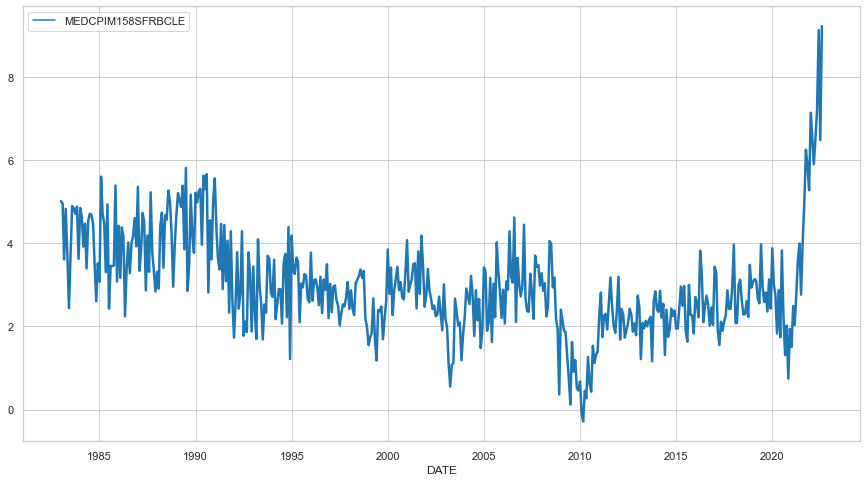

In [2]:
plt.figure(figsize=(15, 8))
ticker = 'MEDCPIM158SFRBCLE'
rd_type = 'fred'
start_date = '1983/01/01'
end_date = '2022/08/31'
CPI_df = DataReader(ticker, rd_type, 
                        start = start_date, end = end_date)
# EXTRA
sns.set_theme(style="whitegrid")
sns.lineplot(data=CPI_df, palette="tab10", linewidth=2.5)

CPI_df

FEDFUNDS

,FEDFUNDS
DATE,
1983-01-01,8.68
1983-02-01,8.51
1983-03-01,8.77
1983-04-01,8.80
1983-05-01,8.63
...,...
2022-04-01,0.33
2022-05-01,0.77
2022-06-01,1.21


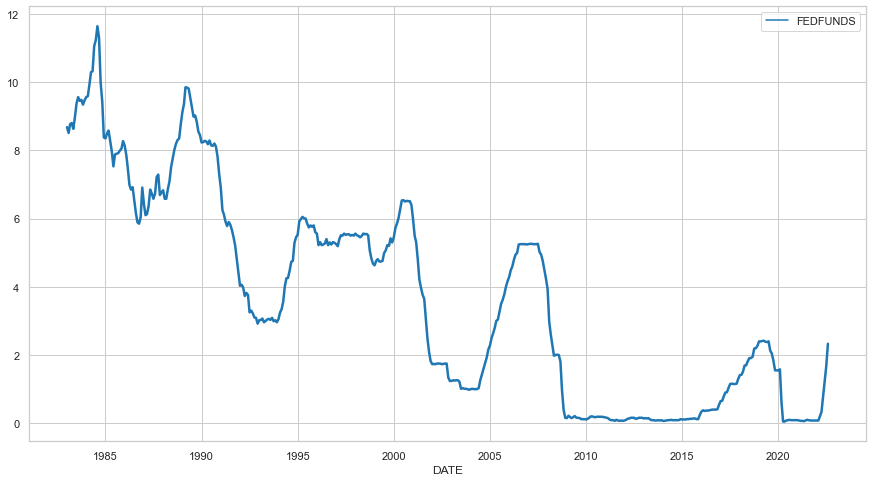

In [3]:
plt.figure(figsize=(15, 8))

ticker = 'FEDFUNDS'
rd_type = 'fred'
start_date = '1983/01/01'
end_date = '2022/08/31'
fed_rate_df = DataReader(ticker, rd_type, 
                        start = start_date, end = end_date)
# EXTRA
sns.set_theme(style="whitegrid")
sns.lineplot(data=fed_rate_df, palette="tab10", linewidth=2.5)

fed_rate_df

In [4]:
#Let's create a copy for later US recessions study
cpi = CPI_df.copy()
fed = fed_rate_df.copy()

CPI vs Fed Rate

In [5]:
#del fed_rate_df['index']
#fed_rate_df

In [6]:
#Recession plots function

def Recessions_plot(ax, start_date, end_date):
    ticker = 'USREC'
    rd_type = 'fred'
    Recession_df = DataReader(ticker, rd_type, 
                            start = start_date, end = end_date) 

    Recession_df['index']= Recession_df.index
    threshold = 0
    ax.fill_between(Recession_df['index'], 0, 1, where=Recession_df[Recession_df.columns[0]] > threshold,
                    color='green', alpha=0.5, transform=ax.get_xaxis_transform())
    return(1)

In [7]:
#Index Correlation function

def Fed_indexes_corr(Primary_df, Secondary_df, 
                          condition = [-inf, inf],
                          shift__=0, 
                          bottom_year = '1/1/1960',
                          top_year = '1/1/2060'):
                          
    plt.figure(figsize=(12, 8))
    Secondary_df['index']= Secondary_df.index
    Primary_df['index']= Primary_df.index
    # make sure on a loop
    Primary_df[Secondary_df.columns[0]] = 0
    
    Secondary_df = Secondary_df[Primary_df['index'] > bottom_year]
    Primary_df = Primary_df[Primary_df['index'] > bottom_year]
    Secondary_df = Secondary_df[Primary_df['index' ] < top_year]   
    Primary_df = Primary_df[Primary_df['index' ] < top_year]
# condition
    Secondary_df = Secondary_df[Primary_df[Primary_df.columns[0]] > condition[0]]
    Primary_df = Primary_df[Primary_df[Primary_df.columns[0]] > condition[0]]
    Primary_df = Primary_df.shift(shift__)
    
#    1st plot
    ax = sns.lineplot(x='index', y =  Primary_df.columns[0],
                      color='red', linewidth=2.5, data=Primary_df)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
# recession bars
    Recessions_plot(ax, bottom_year, top_year)
# 2nd subplot
    ax2 = ax.twinx()
    sns.lineplot(x='index', y=Secondary_df.columns[0], 
                 data=Secondary_df, color='black',
                 linewidth=2.5, ax=ax2)
    if Secondary_df.iloc[0,0] < 99 : ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.show()
#heatmap
    Primary_df[Secondary_df.columns[0]] = Secondary_df[Secondary_df.columns[0]]
    hm = Primary_df.corr()
    sns.heatmap(hm, annot=True)
    plt.show()
    return hm

# CPI vs Fed Rate

CPI: Red; FEDFUNDS: black;


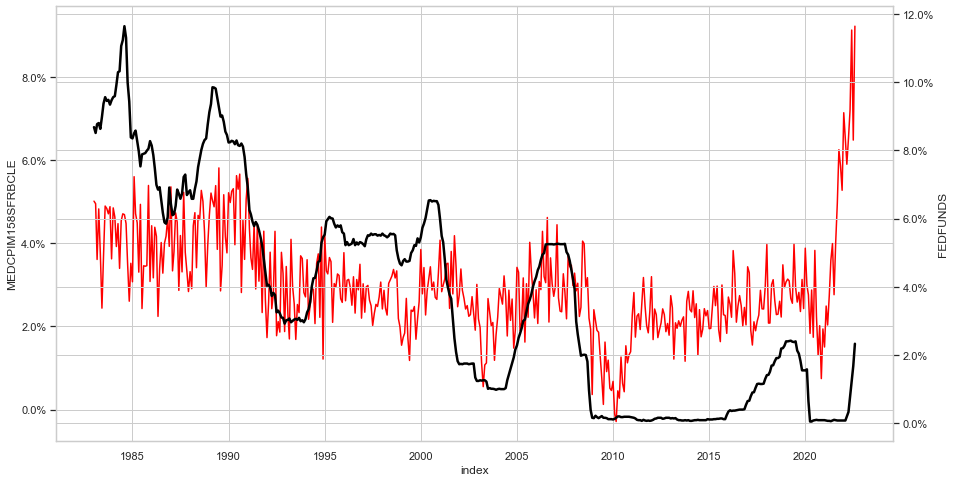

In [8]:
plt.figure(figsize=(15, 8))
CPI_df['index']= CPI_df.index
ax = sns.lineplot(x='index', y=CPI_df.columns[0], color='red', data=CPI_df)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

fed_rate_df['index']= fed_rate_df.index
ax2 = ax.twinx()
sns.lineplot(x='index', y=fed_rate_df.columns[0],color='black', data=fed_rate_df,palette="tab10", linewidth=2.5, ax=ax2)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

print('CPI: Red;', 'FEDFUNDS: black;')
plt.show()

## 1983 to present

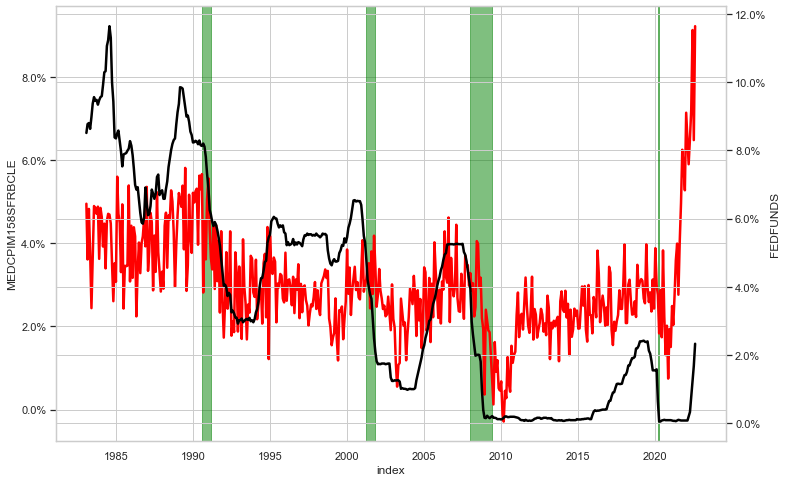

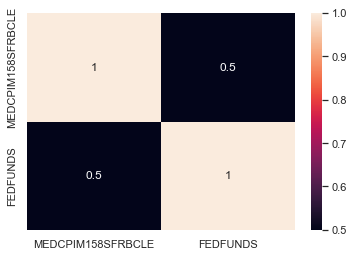

shift: 0    corr: 0.4989296598488078
shift: 0    corr: 0.4989296598488078


In [9]:
#Recession plots (green) and CPI vs FEDFUNDS

maxsh = 0
maxcorr = 0.0
for sh in range(0, 3, 3):
    hm=Fed_indexes_corr(CPI_df, fed_rate_df, shift__= sh, 
                            bottom_year='1983-1-01',
                            top_year='2027-12-31')
    print('shift:', sh, '   corr:', hm.iloc[0,1])
    if hm.iloc[0,1] > maxcorr: 
        maxcorr = hm.iloc[0,1]
        maxsh = sh
print('shift:', maxsh, '   corr:',maxcorr)

**1983 to present: High correlation between CPI & FEDFUNDS (0.5).**

The Fed policy was formulated to raise the Fed rate whenever inflation is above 2% and to lower the Fed rate when inflation is below 2%.

Under this policy, the correlation is 0.50 between CPI and the Fed rate. Figure 8 shows that CPI and the Fed rate track each other — they are correlated.

## 1983 to 1993

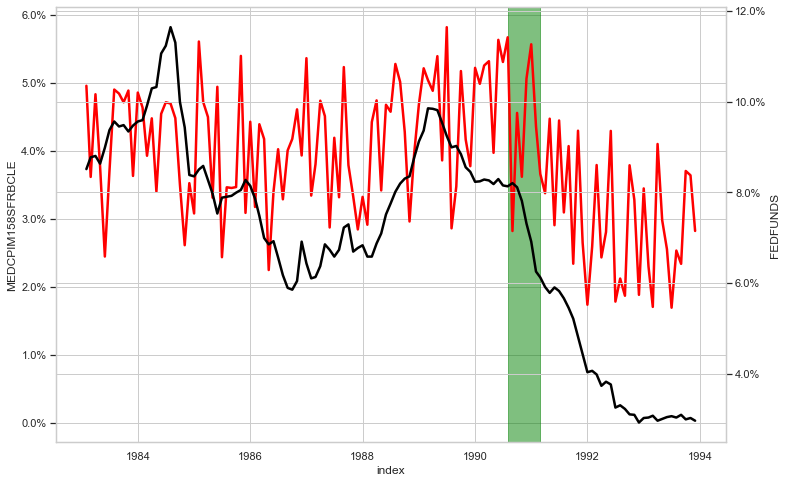

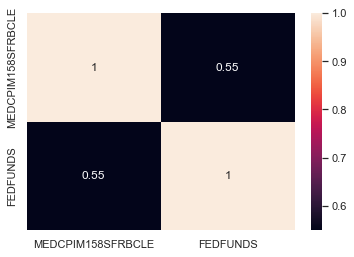

shift: 0    corr: 0.5490694814641562
shift: 0    corr: 0.5490694814641562


In [10]:
#Recession plots (green) and CPI vs FEDFUNDS

maxsh = 0
maxcorr = 0.0
for sh in range(0, 3, 3):
    hm=Fed_indexes_corr(CPI_df, fed_rate_df, shift__= sh, 
                            bottom_year='1983-1-01',
                            top_year='1993-12-31')
    print('shift:', sh, '   corr:', hm.iloc[0,1])
    if hm.iloc[0,1] > maxcorr: 
        maxcorr = hm.iloc[0,1]
        maxsh = sh
print('shift:', maxsh, '   corr:',maxcorr)

**1983 to 1993: Moderate correlation between CPI & FEDFUNDS (0.55).**

## 1983 to 2015

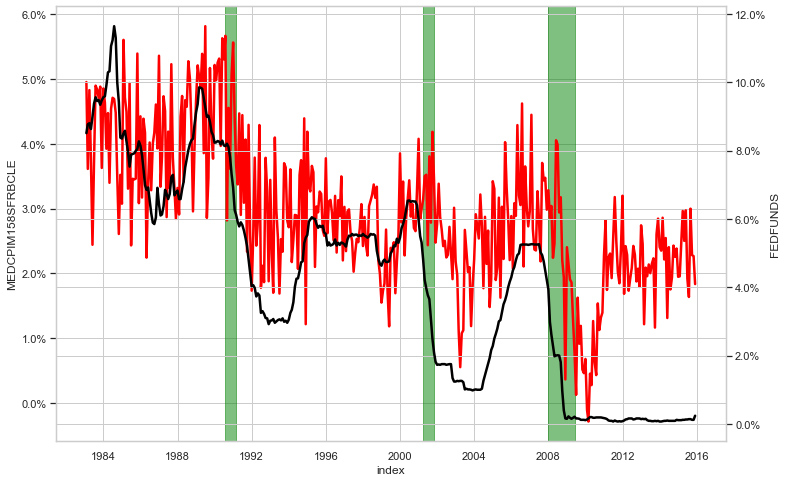

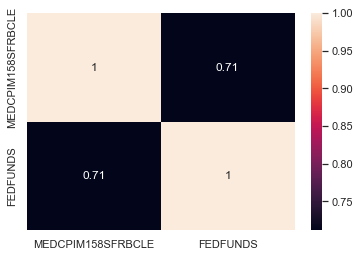

shift: 0    corr: 0.7114482536831033
shift: 0    corr: 0.7114482536831033


In [11]:
#Recession plots (green) and CPI vs FEDFUNDS

maxsh = 0
maxcorr = 0.0
for sh in range(0, 3, 3):
    hm=Fed_indexes_corr(CPI_df, fed_rate_df, shift__= sh, 
                            bottom_year='1983-1-01',
                            top_year='2015-12-31')
    print('shift:', sh, '   corr:', hm.iloc[0,1])
    if hm.iloc[0,1] > maxcorr: 
        maxcorr = hm.iloc[0,1]
        maxsh = sh
print('shift:', maxsh, '   corr:',maxcorr)

**1983 to 2015: High correlation between CPI & FEDFUNDS (0.71).**

## 1983 to 2010

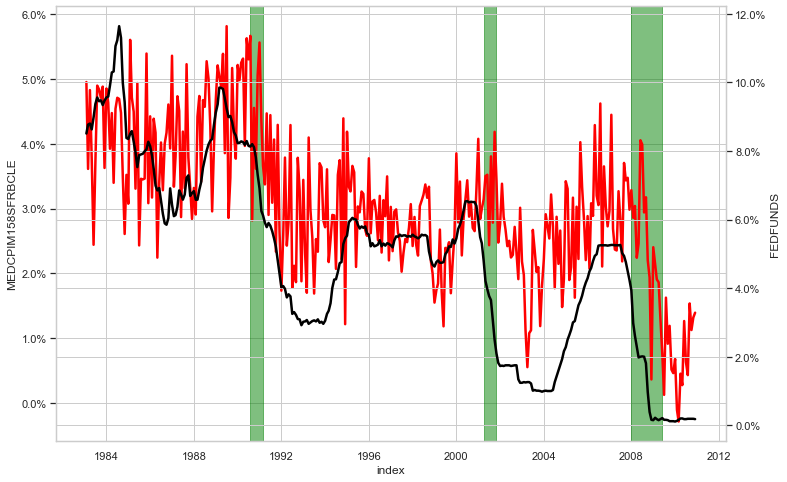

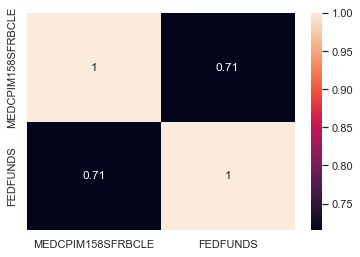

shift: 0    corr: 0.7149217072243267
shift: 0    corr: 0.7149217072243267


In [12]:
#Recession plots (green) and CPI vs FEDFUNDS

maxsh = 0
maxcorr = 0.0
for sh in range(0, 3, 3):
    hm=Fed_indexes_corr(CPI_df, fed_rate_df, shift__= sh, 
                            bottom_year='1983-1-01',
                            top_year='2010-12-31')
    print('shift:', sh, '   corr:', hm.iloc[0,1])
    if hm.iloc[0,1] > maxcorr: 
        maxcorr = hm.iloc[0,1]
        maxsh = sh
print('shift:', maxsh, '   corr:',maxcorr)

**1983 to 2010: High correlation between CPI & FEDFUNDS (0.71).**

## 1990 to 2020

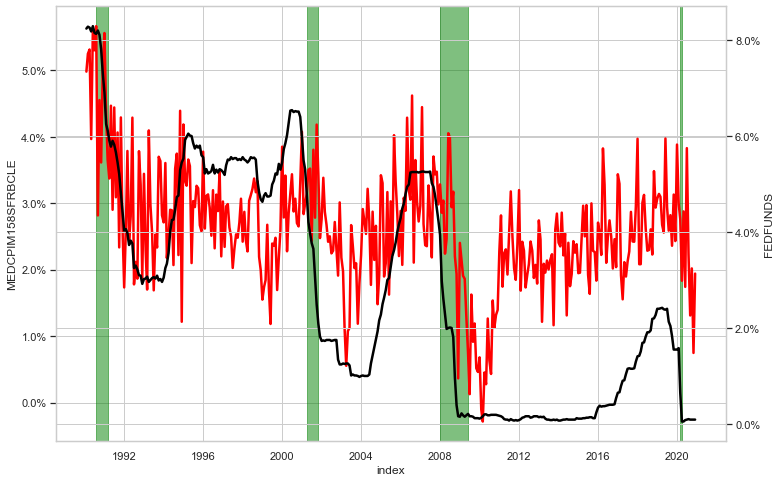

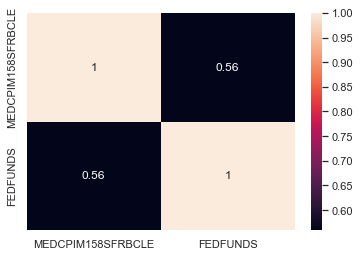

shift: 0    corr: 0.5590882478701534
shift: 0    corr: 0.5590882478701534


In [13]:
#Recession plots (green) and CPI vs FEDFUNDS

maxsh = 0
maxcorr = 0.0
for sh in range(0, 3, 3):
    hm=Fed_indexes_corr(CPI_df, fed_rate_df, shift__= sh, 
                            bottom_year='1990-01-01',
                            top_year='2020-12-31')
    print('shift:', sh, '   corr:', hm.iloc[0,1])
    if hm.iloc[0,1] > maxcorr: 
        maxcorr = hm.iloc[0,1]
        maxsh = sh
print('shift:', maxsh, '   corr:',maxcorr)

**1990 to 2020: High correlation between CPI & FEDFUNDS (0.56).**

## 1990 to 2022

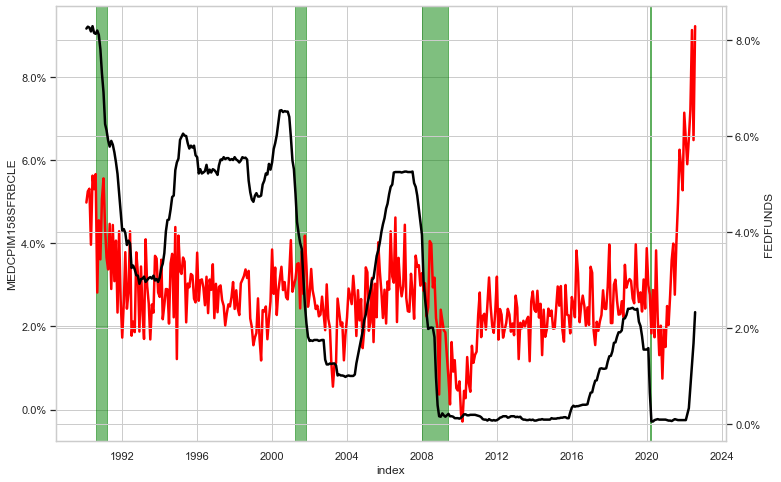

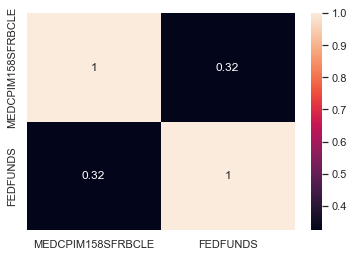

shift: 0    corr: 0.3242663943640798
shift: 0    corr: 0.3242663943640798


In [14]:
#Recession plots (green) and CPI vs FEDFUNDS

maxsh = 0
maxcorr = 0.0
for sh in range(0, 3, 3):
    hm=Fed_indexes_corr(CPI_df, fed_rate_df, shift__= sh, 
                            bottom_year='1990-01-01',
                            top_year='2022-12-31')
    print('shift:', sh, '   corr:', hm.iloc[0,1])
    if hm.iloc[0,1] > maxcorr: 
        maxcorr = hm.iloc[0,1]
        maxsh = sh
print('shift:', maxsh, '   corr:',maxcorr)

**1990 to 2022: Mid correlation between CPI & FEDFUNDS (0.32).**

## 1990 to 2015

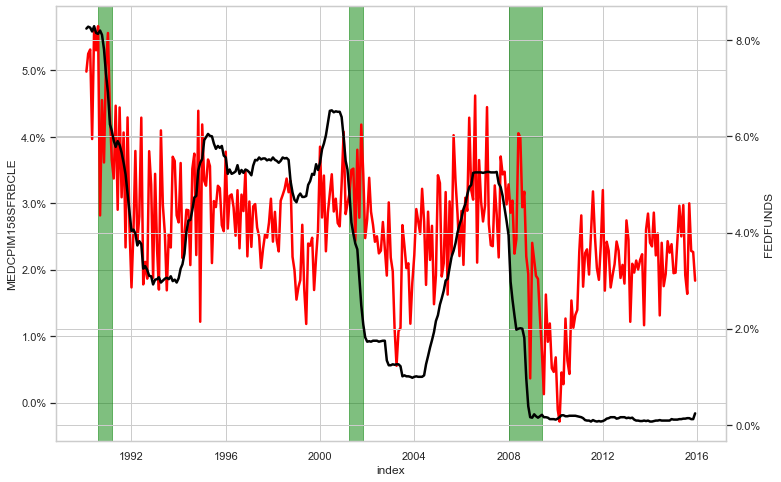

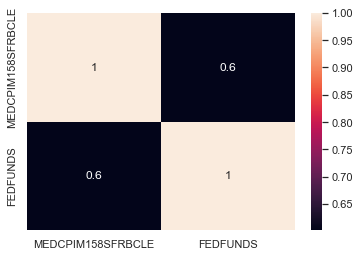

shift: 0    corr: 0.6014151328956309
shift: 0    corr: 0.6014151328956309


In [15]:
#Recession plots (green) and CPI vs FEDFUNDS

maxsh = 0
maxcorr = 0.0
for sh in range(0, 3, 3):
    hm=Fed_indexes_corr(CPI_df, fed_rate_df, shift__= sh, 
                            bottom_year='1990-01-01',
                            top_year='2015-12-31')
    print('shift:', sh, '   corr:', hm.iloc[0,1])
    if hm.iloc[0,1] > maxcorr: 
        maxcorr = hm.iloc[0,1]
        maxsh = sh
print('shift:', maxsh, '   corr:',maxcorr)

**1990 to 2015: High correlation between CPI & FEDFUNDS (0.6).**

## 1990 to 2010

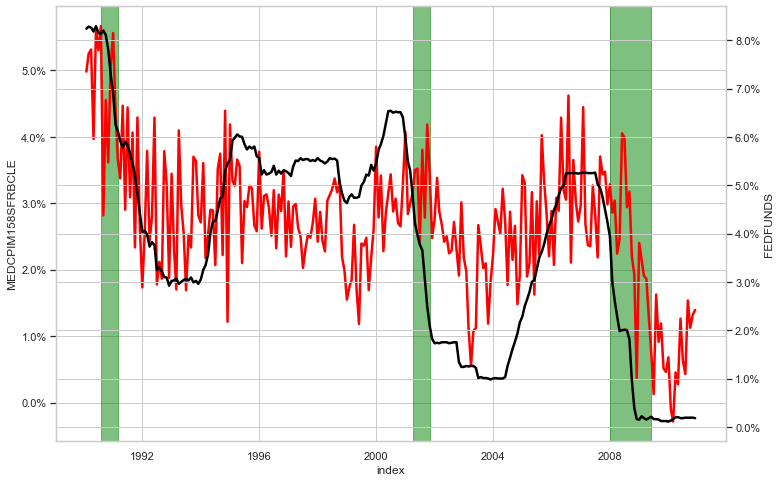

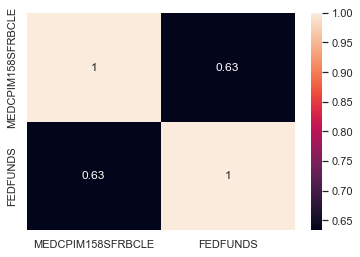

shift: 0    corr: 0.6329226859098129
shift: 0    corr: 0.6329226859098129


In [16]:
#Recession plots (green) and CPI vs FEDFUNDS

maxsh = 0
maxcorr = 0.0
for sh in range(0, 3, 3):
    hm=Fed_indexes_corr(CPI_df, fed_rate_df, shift__= sh, 
                            bottom_year='1990-01-01',
                            top_year='2010-12-31')
    print('shift:', sh, '   corr:', hm.iloc[0,1])
    if hm.iloc[0,1] > maxcorr: 
        maxcorr = hm.iloc[0,1]
        maxsh = sh
print('shift:', maxsh, '   corr:',maxcorr)

**1990 to 2010: High correlation between CPI & FEDFUNDS (0.63).**

## 1995 to 2005

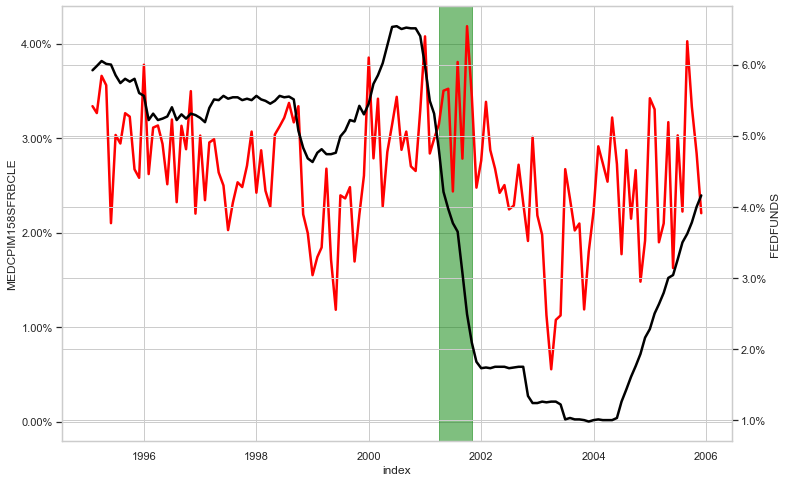

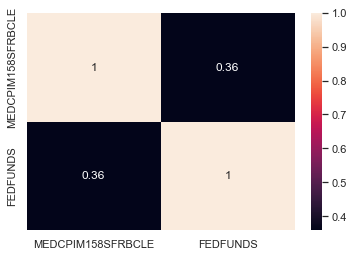

shift: 0    corr: 0.3580553376363413
shift: 0    corr: 0.3580553376363413


In [17]:
#Recession plots (green) and CPI vs FEDFUNDS

maxsh = 0
maxcorr = 0.0
for sh in range(0, 3, 3):
    hm=Fed_indexes_corr(CPI_df, fed_rate_df, shift__= sh, 
                            bottom_year='1995-1-01',
                            top_year='2005-12-31')
    print('shift:', sh, '   corr:', hm.iloc[0,1])
    if hm.iloc[0,1] > maxcorr: 
        maxcorr = hm.iloc[0,1]
        maxsh = sh
print('shift:', maxsh, '   corr:',maxcorr)

**1995 to 2005: correlation between CPI & FEDFUNDS (0.36).**

## 1995 to 2015

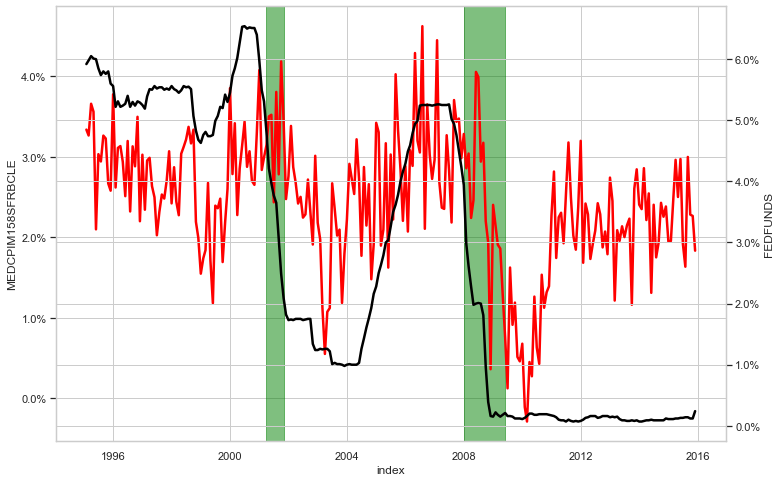

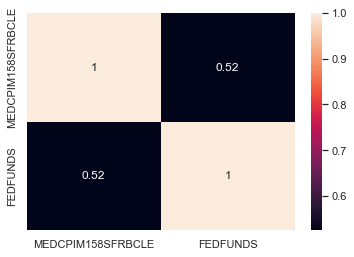

shift: 0    corr: 0.5243553088863093
shift: 0    corr: 0.5243553088863093


In [18]:
#Recession plots (green) and CPI vs FEDFUNDS

maxsh = 0
maxcorr = 0.0
for sh in range(0, 3, 3):
    hm=Fed_indexes_corr(CPI_df, fed_rate_df, shift__= sh, 
                            bottom_year='1995-1-01',
                            top_year='2015-12-31')
    print('shift:', sh, '   corr:', hm.iloc[0,1])
    if hm.iloc[0,1] > maxcorr: 
        maxcorr = hm.iloc[0,1]
        maxsh = sh
print('shift:', maxsh, '   corr:',maxcorr)

**1995 to 2015: correlation between CPI & FEDFUNDS (0.52).**

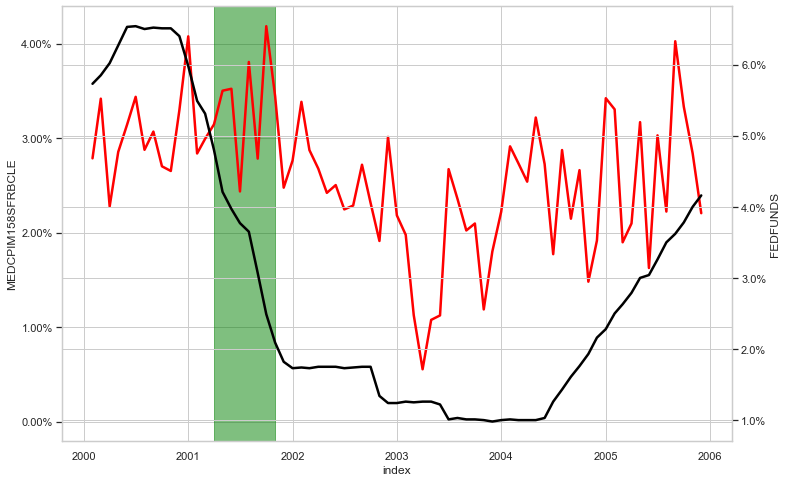

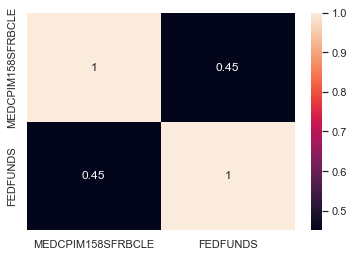

shift: 0    corr: 0.4500349873617904
shift: 0    corr: 0.4500349873617904


In [19]:
#Recession plots (green) and CPI vs FEDFUNDS

maxsh = 0
maxcorr = 0.0
for sh in range(0, 3, 3):
    hm=Fed_indexes_corr(CPI_df, fed_rate_df, shift__= sh, 
                            bottom_year='2000-1-01',
                            top_year='2005-12-31')
    print('shift:', sh, '   corr:', hm.iloc[0,1])
    if hm.iloc[0,1] > maxcorr: 
        maxcorr = hm.iloc[0,1]
        maxsh = sh
print('shift:', maxsh, '   corr:',maxcorr)

## 2003 to 2013

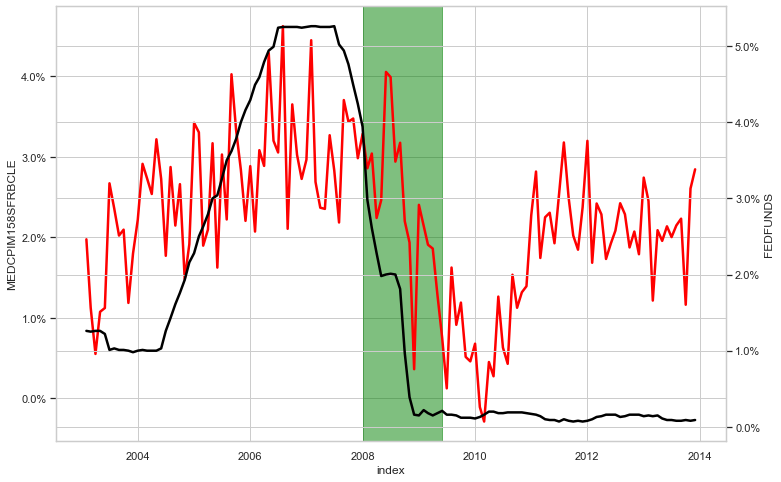

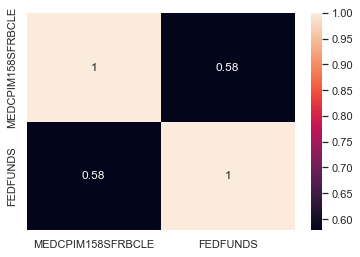

shift: 0    corr: 0.5780246531441803
shift: 0    corr: 0.5780246531441803


In [20]:
#Recession plots (green) and CPI vs FEDFUNDS

maxsh = 0
maxcorr = 0.0
for sh in range(0, 3, 3):
    hm=Fed_indexes_corr(CPI_df, fed_rate_df, shift__= sh, 
                            bottom_year='2003-1-01',
                            top_year='2013-12-30')
    print('shift:', sh, '   corr:', hm.iloc[0,1])
    if hm.iloc[0,1] > maxcorr: 
        maxcorr = hm.iloc[0,1]
        maxsh = sh
print('shift:', maxsh, '   corr:',maxcorr)

**2003 to 2013: correlation between CPI & FEDFUNDS (0.58).**

## 2010 to 2022

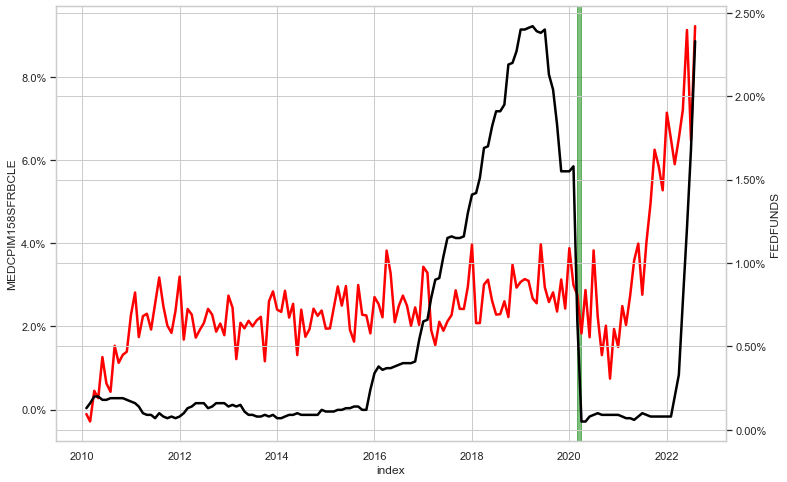

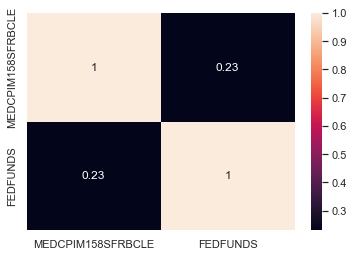

shift: 0    corr: 0.23018749879090258
shift: 0    corr: 0.23018749879090258


In [21]:
#Recession plots (green) and CPI vs FEDFUNDS

maxsh = 0
maxcorr = 0.0
for sh in range(0, 3, 3):
    hm=Fed_indexes_corr(CPI_df, fed_rate_df, shift__= sh, 
                            bottom_year='2010-1-01',
                            top_year='2022-12-30')
    print('shift:', sh, '   corr:', hm.iloc[0,1])
    if hm.iloc[0,1] > maxcorr: 
        maxcorr = hm.iloc[0,1]
        maxsh = sh
print('shift:', maxsh, '   corr:',maxcorr)

**2010 to 2022: Mid correlation between CPI & FEDFUNDS (0.23).**

## 2015 to 2022

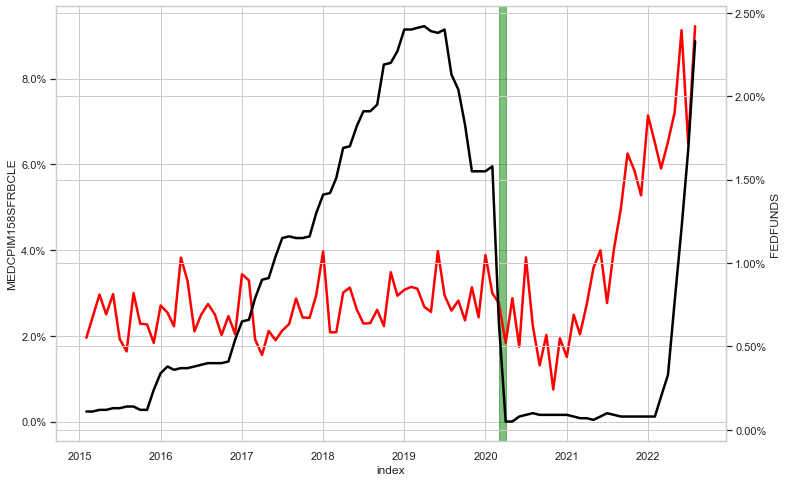

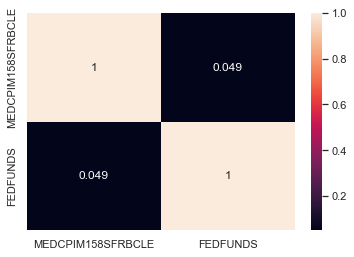

shift: 0    corr: 0.0489087603602484
shift: 0    corr: 0.0489087603602484


In [22]:
#Recession plots (green) and CPI vs FEDFUNDS

maxsh = 0
maxcorr = 0.0
for sh in range(0, 3, 3):
    hm=Fed_indexes_corr(CPI_df, fed_rate_df, shift__= sh, 
                            bottom_year='2015-01-01',
                            top_year='2022-12-31')
    print('shift:', sh, '   corr:', hm.iloc[0,1])
    if hm.iloc[0,1] > maxcorr: 
        maxcorr = hm.iloc[0,1]
        maxsh = sh
print('shift:', maxsh, '   corr:',maxcorr)

**2015 to 2022: No correlation between CPI & FEDFUNDS (0.05).**

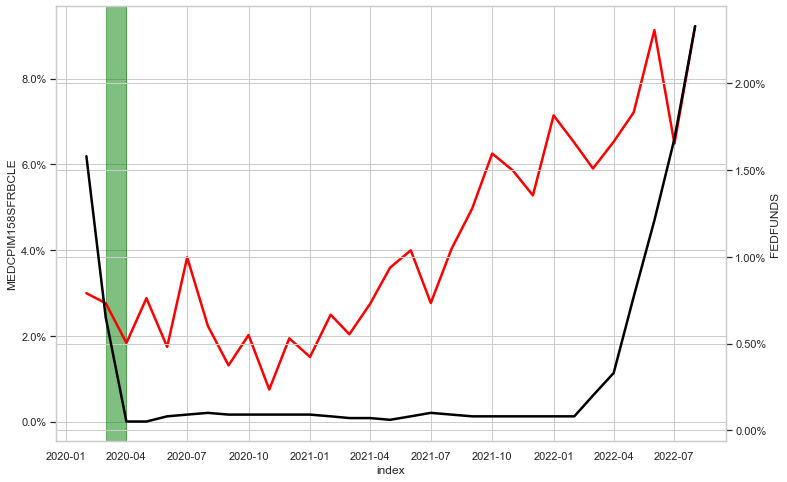

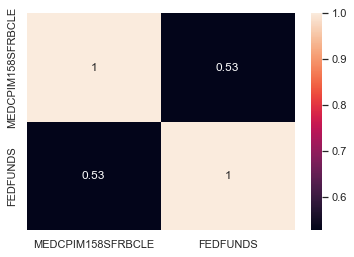

shift: 0    corr: 0.5268190357432351
shift: 0    corr: 0.5268190357432351


In [23]:
#Recession plots (green) and CPI vs FEDFUNDS

maxsh = 0
maxcorr = 0.0
for sh in range(0, 3, 3):
    hm=Fed_indexes_corr(CPI_df, fed_rate_df, shift__= sh, 
                            bottom_year='2020-01-01',
                            top_year='2022-12-31')
    print('shift:', sh, '   corr:', hm.iloc[0,1])
    if hm.iloc[0,1] > maxcorr: 
        maxcorr = hm.iloc[0,1]
        maxsh = sh
print('shift:', maxsh, '   corr:',maxcorr)

Creating results table with Period, Correlation and Correlation's desctiption.

In [24]:
data = {'Period':  ['1983 - present', '1983 - 1993','1983 - 2015', '1983 - 2010', '1990 - 2020',
                    '1990 - 2022', '1990 - 2015','1990 - 2010','1995 - 2005','1995 - 2015','2010 - 2022','2015 - 2022','2003 - 2013'],
        'Correlation': ['0.5', '0.55','0.71','0.71','0.56','0.32','0.6','0.63','0.36','0.52','0.23','0.05','0.58']
        }

corr_df = pd.DataFrame(data)
corr_df = corr_df.sort_values(by='Correlation', ascending=False)
#corr_df

In [25]:
#Change object to float
corr_df['Correlation'] = corr_df['Correlation'].astype(float)
print(corr_df.dtypes)

Period          object
Correlation    float64
dtype: object


In [26]:
#Adding a new column with correlation's description
result = []
for value in corr_df["Correlation"]:
    if value >= 0.6:
        result.append("Strong Association")
    elif value < 0.6 and value > 0.4:
        result.append("Moderate Association")
    elif value < 0.4 and value > 0.2:
        result.append("Weak Association")
    else:
        result.append("No Association")
      
corr_df["Description"] = result

## Results

In [27]:
print(corr_df)

            Period  Correlation           Description
2      1983 - 2015         0.71    Strong Association
3      1983 - 2010         0.71    Strong Association
7      1990 - 2010         0.63    Strong Association
6      1990 - 2015         0.60    Strong Association
12     2003 - 2013         0.58  Moderate Association
4      1990 - 2020         0.56  Moderate Association
1      1983 - 1993         0.55  Moderate Association
9      1995 - 2015         0.52  Moderate Association
0   1983 - present         0.50  Moderate Association
8      1995 - 2005         0.36      Weak Association
5      1990 - 2022         0.32      Weak Association
10     2010 - 2022         0.23      Weak Association
11     2015 - 2022         0.05        No Association


As we can see from the above table,  **the highest correlation** between the inflation and the fed rate is between  **1983 - 2015 (0.71) and 1983-2010 (0.71). The lowest correlation is between 2015 and 2022(0.05).**

High inflation and fed rates proceeded all US recessions by
Inflation peaks preceded all four national recessions by about three months or one quarter.


# US Recessions

Let's study the correlation during US national recessions. For each recession we will create three time periods to analyze:
- 1 Year Before Recession
- Recessiom
- 1 Year After Recession

We will analyze following:
1. How CPI changes: Before-During-After recessions
2. How FED RATES changes: Before-During-After recessions
3. Correlation between CPI & FED RATES Pre, Post and During recession periods. 

## Early 1990s recession.

- July 1990 – March 1991: 8 months.

In [28]:
cpi_90 = cpi.query("'1990' <= DATE < 1992")

fed_90 = fed.query("'1990' <= DATE < 1992")

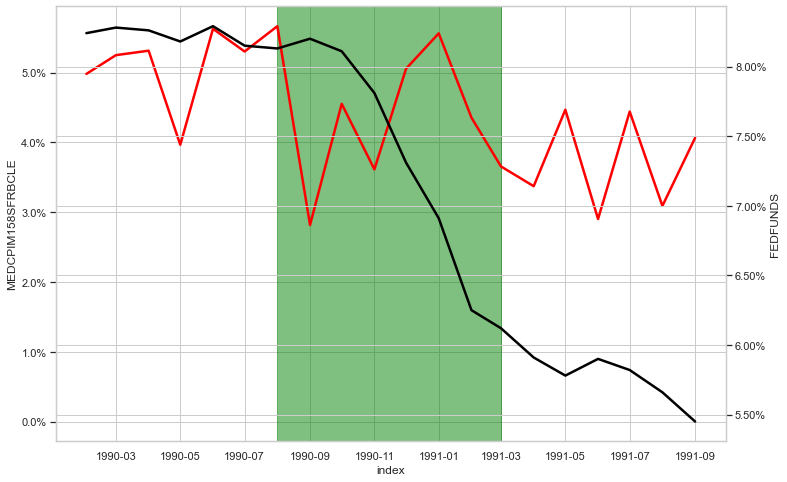

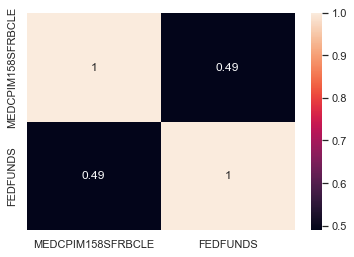

shift: 0    corr: 0.4888343404954489


In [29]:
#Recession plots (green) and CPI vs FEDFUNDS

maxsh = 0
maxcorr = 0.0
for sh in range(0, 3, 3):
    hm=Fed_indexes_corr(cpi_90, fed_90, shift__= sh, 
                            bottom_year='1990-01-01',
                            top_year='1991-09-30')
    print('shift:', sh, '   corr:', hm.iloc[0,1])

In [30]:
#Mean CPI July 1990 – March 1991: 8 months.
cpi_90_start = cpi.query("'1990.06.01' <= DATE < '1991.04.01'")
cpi_90_start = cpi_90_start['MEDCPIM158SFRBCLE'].mean().round(2)
cpi_90_start

#year before
cpi_90_bfr = cpi.query("'1989.06.01' <= DATE < '1990.06.01'")
cpi_90_bfr = cpi_90_bfr['MEDCPIM158SFRBCLE'].mean().round(2)
cpi_90_bfr

#year after
cpi_90_aft = cpi.query("'1991.04.01' <= DATE < '1992.04.01'")
cpi_90_aft = cpi_90_aft['MEDCPIM158SFRBCLE'].mean().round(2)
cpi_90_aft

print('1y before:',cpi_90_bfr)
print('Rec. start:',cpi_90_start)
print('1y after:',cpi_90_aft)

1y before: 4.49
Rec. start: 4.62
1y after: 3.31


In [31]:
#Mean FEDFUNDS July 1990 – March 1991: 8 months.
fed_90_start = fed.query("'1990.06.01' <= DATE < '1991.04.01'")
fed_90_start = fed_90_start['FEDFUNDS'].mean().round(2)
fed_90_start

#year before
fed_90_bfr = fed.query("'1989.06.01' <= DATE < '1990.06.01'")
fed_90_bfr = fed_90_bfr['FEDFUNDS'].mean().round(2)
fed_90_bfr

#year after
fed_90_aft = fed.query("'1991.04.01' <= DATE < '1992.04.01'")
fed_90_aft = fed_90_aft['FEDFUNDS'].mean().round(2)
fed_90_aft

print('1y before:',fed_90_bfr)
print('Rec. start:',fed_90_start)
print('1y after:',fed_90_aft)

1y before: 8.65
Rec. start: 7.53
1y after: 5.09


In [32]:
data = {'CPI': [cpi_90_bfr,cpi_90_start, cpi_90_aft],
        'FED RATE': [fed_90_bfr,fed_90_start,fed_90_aft]}
  
# Creates pandas DataFrame.
df_90_rec = pd.DataFrame(data, index=['1 Year Before',
                               '1990s Recession',
                               '1 Year After'])

df_90_rec

,CPI,FED RATE
1 Year Before,4.49,8.65
1990s Recession,4.62,7.53
1 Year After,3.31,5.09


Moderate Correlation: 0.49

* Mean CPI during recession was approximately the same as one year prior to recession (2.9% higher).
* Mean CPI one year after recession has decreased by 28.35%.

* Mean FED RATE during recession was 12.95% lower than one year prior to recession.
* Mean FED RATE one year after recession decreased by 32.4%.

## Early 2000s recession

March 2001 – November 2001:	8 months

In [33]:
cpi_00 = cpi.query("'2000' <= DATE < 2003")

fed_00 = fed.query("'2000' <= DATE < 2003")

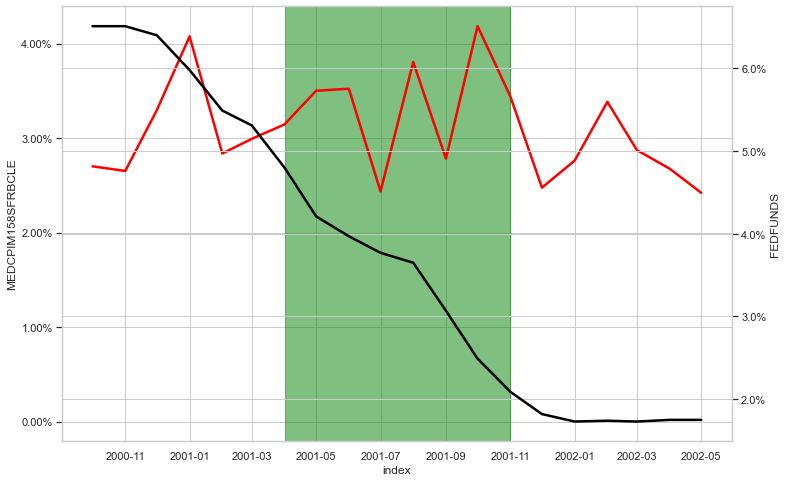

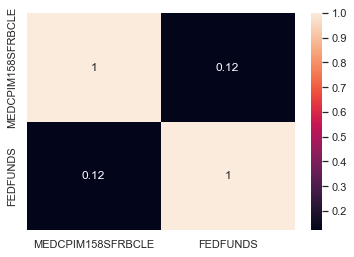

shift: 0    corr: 0.12176863400399146


In [34]:
#Recession plots (green) and CPI vs FEDFUNDS

maxsh = 0
maxcorr = 0.0
for sh in range(0, 3, 3):
    hm=Fed_indexes_corr(cpi_00, fed_00, shift__= sh, 
                            bottom_year='2000-09-01',
                            top_year='2002-05-31')
    print('shift:', sh, '   corr:', hm.iloc[0,1])

In [35]:
#Mean CPI March 2001 – November 2001: 8 months
cpi_00_start = cpi.query("'2001.03.01' <= DATE < '2001.12.01'")
cpi_00_start = cpi_00_start['MEDCPIM158SFRBCLE'].mean().round(2)
cpi_00_start

#year before
cpi_00_bfr = cpi.query("'2000.03.01' <= DATE < '2001.03.01'")
cpi_00_bfr = cpi_00_bfr['MEDCPIM158SFRBCLE'].mean().round(2)
cpi_00_bfr

#year after
cpi_00_aft = cpi.query("'2001.12.01' <= DATE < '2002.12.01'")
cpi_00_aft = cpi_00_aft['MEDCPIM158SFRBCLE'].mean().round(2)
cpi_00_aft

print('1y before:',cpi_00_bfr)
print('Rec. start:',cpi_00_start)
print('1y after:',cpi_00_aft)

1y before: 3.05
Rec. start: 3.31
1y after: 2.55


In [36]:
#Mean FED RATE March 2001 – November 2001: 8 months
fed_00_start = fed.query("'2001.03.01' <= DATE < '2001.12.01'")
fed_00_start = fed_00_start['FEDFUNDS'].mean().round(2)
fed_00_start

#year before
fed_00_bfr = fed.query("'2000.03.01' <= DATE < '2001.03.01'")
fed_00_bfr = fed_00_bfr['FEDFUNDS'].mean().round(2)
fed_00_bfr

#year after
fed_00_aft = fed.query("'2001.12.01' <= DATE < '2002.12.01'")
fed_00_aft = fed_00_aft['FEDFUNDS'].mean().round(2)
fed_00_aft

print('1y before:',fed_00_bfr)
print('Rec. start:',fed_00_start)
print('1y after:',fed_00_aft)

1y before: 6.26
Rec. start: 3.71
1y after: 1.72


In [37]:
data = {'CPI': [cpi_00_bfr, cpi_00_start, cpi_00_aft],
        'FED RATE': [fed_00_bfr,fed_00_start, fed_00_aft]}
  
# Creates pandas DataFrame.
df_00_rec = pd.DataFrame(data, index=['1 Year Before',
                               '2000s Recession',
                               '1 Year After'])

df_00_rec

,CPI,FED RATE
1 Year Before,3.05,6.26
2000s Recession,3.31,3.71
1 Year After,2.55,1.72


No Correlation: 0.12

* Mean CPI during recession was increased by 8.52% in comparison to one year prior to recession.
* Mean CPI one year after recession has decreased by 22.96%.

* Mean FED RATE during recession was 40.73% lower than one year prior to recession.
* Mean FED RATE one year after recession decreased by 53.64%.

## Great Recession

December 2007 –June 2009: 1 year 6 months

In [38]:
cpi_gr = cpi.query("'2007' <= DATE < 2010")

fed_gr = fed.query("'2007' <= DATE < 2010")

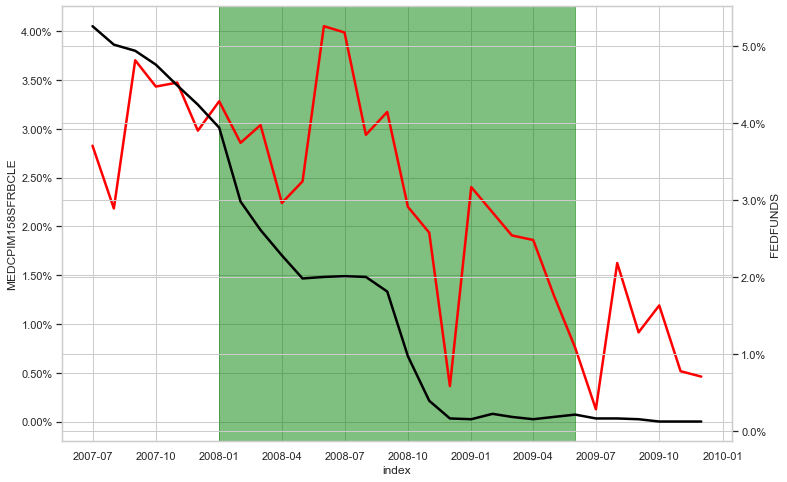

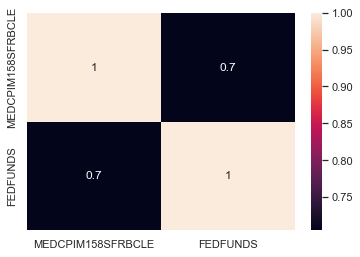

shift: 0    corr: 0.704718789711045


In [39]:
#Recession plots (green) and CPI vs FEDFUNDS

maxsh = 0
maxcorr = 0.0
for sh in range(0, 3, 3):
    hm=Fed_indexes_corr(cpi_gr, fed_gr, shift__= sh, 
                            bottom_year='2007-06-01',
                            top_year='2009-12-31')
    print('shift:', sh, '   corr:', hm.iloc[0,1])

In [40]:
#Mean CPI December 2007 –June 2009: 1 year 6 months
cpi_gr_start = cpi.query("'2007.12.01' <= DATE < '2009.07.01'")
cpi_gr_start = cpi_gr_start['MEDCPIM158SFRBCLE'].mean().round(2)
cpi_gr_start

#year before
cpi_gr_bfr = cpi.query("'2006.12.01' <= DATE < '2007.12.01'")
cpi_gr_bfr = cpi_gr_bfr['MEDCPIM158SFRBCLE'].mean().round(2)
cpi_gr_bfr

#year after
cpi_gr_aft = cpi.query("'2009.07.01' <= DATE < '2010.07.01'")
cpi_gr_aft = cpi_gr_aft['MEDCPIM158SFRBCLE'].mean().round(2)
cpi_gr_aft

print('1y before:',cpi_gr_bfr)
print('Rec. start:',cpi_gr_start)
print('1y after:',cpi_gr_aft)

1y before: 3.04
Rec. start: 2.42
1y after: 0.59


In [41]:
#Mean FEDFUNDS December 2007 –June 2009: 1 year 6 months
fed_gr_start = fed.query("'2007.12.01' <= DATE < '2009.07.01'")
fed_gr_start = fed_gr_start['FEDFUNDS'].mean().round(2)
fed_gr_start

#year before
fed_gr_bfr = fed.query("'2006.12.01' <= DATE < '2007.12.01'")
fed_gr_bfr = fed_gr_bfr['FEDFUNDS'].mean().round(2)
fed_gr_bfr

#year after
fed_gr_aft = fed.query("'2009.07.01' <= DATE < '2010.07.01'")
fed_gr_aft = fed_gr_aft['FEDFUNDS'].mean().round(2)
fed_gr_aft

print('1y before:',fed_gr_bfr)
print('Rec. start:',fed_gr_start)
print('1y after:',fed_gr_aft)

1y before: 5.1
Rec. start: 1.5
1y after: 0.15


In [42]:
data = {'CPI': [cpi_gr_bfr,cpi_gr_start, cpi_gr_aft],
        'FED RATE': [fed_gr_bfr,fed_gr_start,fed_gr_aft]}
  
# Creates pandas DataFrame.
df_gr_rec = pd.DataFrame(data, index=['1 Year Before',
                               'GR Recession',
                               '1 Year After'])

df_gr_rec

,CPI,FED RATE
1 Year Before,3.04,5.10
GR Recession,2.42,1.50
1 Year After,0.59,0.15


Strong Correlation: 0.7

* Mean CPI during recession was decreased by 20.39% in comparison to one year prior to recession.
* Mean CPI one year after recession has decreased by 75.62%.

* Mean FED RATE during recession was 70.59% lower than one year prior to recession.
* Mean FED RATE one year after recession decreased by 90%.

## COVID-19 recession

February 2020 – April 2020: 2 months

In [43]:
cpi_19 = cpi.query("'2019' <= DATE < 2021")

fed_19 = fed.query("'2019' <= DATE < 2021")

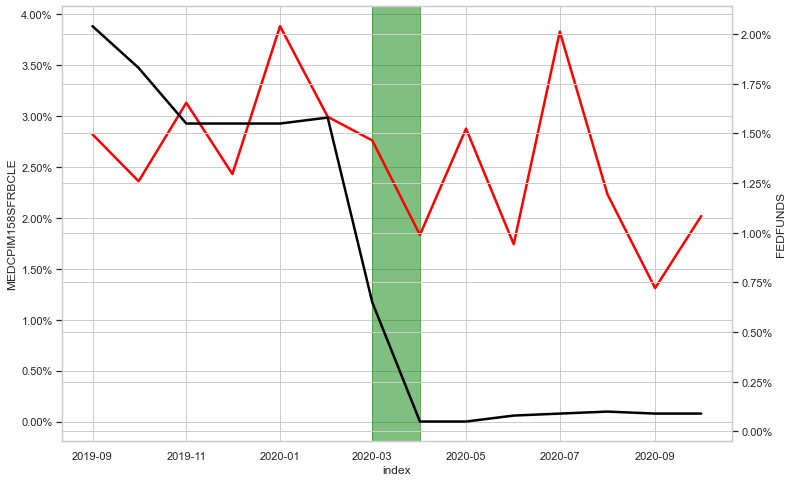

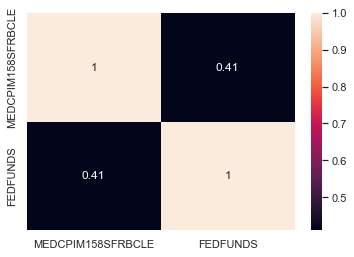

shift: 0    corr: 0.41032774121963256


In [44]:
#Recession plots (green) and CPI vs FEDFUNDS

maxsh = 0
maxcorr = 0.0
for sh in range(0, 3, 3):
    hm=Fed_indexes_corr(cpi_19, fed_19, shift__= sh, 
                            bottom_year='2019-08-01',
                            top_year='2020-10-31')
    print('shift:', sh, '   corr:', hm.iloc[0,1])

In [45]:
#Mean CPI February 2020 – April 2020: 2 months
cpi_19_start = cpi.query("'2020.02.01' <= DATE < '2020.05.01'")
cpi_19_start = cpi_19_start['MEDCPIM158SFRBCLE'].mean().round(2)
cpi_19_start

#year before
cpi_19_bfr = cpi.query("'2019.02.01' <= DATE < '2020.02.01'")
cpi_19_bfr = cpi_19_bfr['MEDCPIM158SFRBCLE'].mean().round(2)
cpi_19_bfr

#year after
cpi_19_aft = cpi.query("'2020.05.01' <= DATE < '2021.05.01'")
cpi_19_aft = cpi_19_aft['MEDCPIM158SFRBCLE'].mean().round(2)
cpi_19_aft

print('1y before:',cpi_19_bfr)
print('Rec. start:',cpi_19_start)
print('1y after:',cpi_19_aft)

1y before: 2.97
Rec. start: 2.53
1y after: 2.12


In [46]:
#Mean FEDFUNDS February 2020 – April 2020: 2 months
fed_19_start = fed.query("'2020.02.01' <= DATE < '2020.05.01'")
fed_19_start = fed_19_start['FEDFUNDS'].mean().round(2)
fed_19_start

#year before
fed_19_bfr = fed.query("'2019.02.01' <= DATE < '2020.02.01'")
fed_19_bfr = fed_19_bfr['FEDFUNDS'].mean().round(2)
fed_19_bfr

#year after
fed_19_aft = fed.query("'2020.05.01' <= DATE < '2021.05.01'")
fed_19_aft = fed_19_aft['FEDFUNDS'].mean().round(2)
fed_19_aft

print('1y before:',fed_19_bfr)
print('Rec. start:',fed_19_start)
print('1y after:',fed_19_aft)

1y before: 2.09
Rec. start: 0.76
1y after: 0.08


In [47]:
data = {'CPI': [cpi_19_bfr,cpi_19_start, cpi_19_aft],
        'FED RATE': [fed_19_bfr,fed_19_start,fed_19_aft]}
  
# Creates pandas DataFrame.
df_19_rec = pd.DataFrame(data, index=['1 Year Before',
                               'Covid-19 Recession',
                               '1 Year After'])

df_19_rec

,CPI,FED RATE
1 Year Before,2.97,2.09
Covid-19 Recession,2.53,0.76
1 Year After,2.12,0.08


Weak/Moderate Correlation: 0.41

* Mean CPI during recession decreased by 14.81% in comparison to one year prior to recession.
* Mean CPI one year after recession decreased by 15.54%.

* Mean FED RATE during recession was 63.64% lower than one year prior to recession.
* Mean FED RATE one year after recession decreased by 89.47%.

## Results

In [48]:
df_90_rec

,CPI,FED RATE
1 Year Before,4.49,8.65
1990s Recession,4.62,7.53
1 Year After,3.31,5.09


**Early 1990s recession**

Moderate correlation during recession (0.49) corresponds to an overall 1983-1993 correlation (0.55).

* Mean CPI stable pre-recession and decreased by 28% after recession.
* Mean FED REATE decreased by 13% during recession and decreased additionally 32% post-recession. 

In [49]:
df_00_rec

,CPI,FED RATE
1 Year Before,3.05,6.26
2000s Recession,3.31,3.71
1 Year After,2.55,1.72


**Early 2000s recession**

Very Weak Correlation during recession (0.12) vs Weak Correlation (0.36) during overall 1995-2005.

* Mean CPI increased by 8.52% during recession anddecre ased by 22.96% post-recession.

* Mean FED RATE decreased by 40.73% during recession and decreased additionally by 53.64% after recession.

In [50]:
df_gr_rec

,CPI,FED RATE
1 Year Before,3.04,5.10
GR Recession,2.42,1.50
1 Year After,0.59,0.15


**Great Recession**

The correlation between CPI & FED RATE increased from moderate overall correlation 2003-2013 (0.58) to Strong correlation (0.7) during recession.

* Mean CPI decreased by 20.39% during recession and decreased additionally by 75.62% post recession.

* Mean FED RATE decreased by 70.59% during recession and decreased additionally by 90% post recession.

In [51]:
df_19_rec

,CPI,FED RATE
1 Year Before,2.97,2.09
Covid-19 Recession,2.53,0.76
1 Year After,2.12,0.08


CPI & FED RATE showed Moderate Correlation during recession (0.41), in comparison to zero correlation during 2015-2022 (0.05).

* Mean CPI decreased by 14.81% during recession and decreased additionally by 15.54% post-recession.

* Mean FED RATE decreased by 63.64% during recession and decreased additionally by 89.47% post-recession.

# Conclusion

There is a **strong correlation** between the CPI and the Fed Rate between  **1983 - 2015 (0.71) and 1983-2010 (0.71)**.

As we study more recent time periods (**2010-2022**) the correlation between inflation and the Fed Rate **weakens (0.23)** and eventually **drops to zero at 2015-2022 (0.05).** 

However the correlation between CPI & the Fed Rate increased during the last two recessions, despite weak or absent overall correlation during the recent period of time:
- During Covid-19 recession, the very weak correlation increased from 0.05 to Moderate 0.41. Even during the Great recession 2007-2009, the correlation between CPI & the Fed Rate during recession was much stronger (strong correlation, 0.7) than during the overall period of 2003-2013 (moderate correlation, 0.58). 

High inflation and fed rates proceeded all US recessions. Therefore, we should keep a finger on the pulse and expect an increasing correlation between inflation and the Fed Rate signalizing about recession withing a few months.

___
<p><img style="display: block; margin-left: auto; margin-right: auto;" src="https://avatars.githubusercontent.com/u/99581812?v=4" alt="" width="89" height="89" /></p>
<p style="text-align: center;">Connect with me:</p>
<p style="text-align: center;"><a href="https://t.me/gavrilov_se" target="blank"><img src="https://www.svgrepo.com/show/349527/telegram.svg" alt="Telegram_Alexander_Gavrilov_Data_Scientist" width="40" height="30" align="center" /></a></p>
<p style="text-align: center;"><a href="mailto:alexander@gavrilov.se" target="blank"><img src="https://www.clipartmax.com/png/full/91-913506_computer-icons-email-address-clip-art-icon-email-vector-png.png" alt="Email_Alexander_Gavrilov_Data_Scientist" width="30" height="30" align="center" /></a>&nbsp;</p>